In [1]:
%load_ext autoreload
%autoreload 2
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal
from just_claw import TransmonClaw
# ?metal.qlibrary.core.QComponent.add_qgeometry

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

# dir(QComponent)
cpw_width = '11.7um'

design._chips.main.size.size_x = '5mm'
design._chips.main.size.size_y = '5mm'
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

from collections import OrderedDict

import numpy as np

xmon1_options = dict(
    connection_pads = dict(
        readout = dict(
            connector_location='90',
            connector_type='0',
            claw_length="1um",
            ground_spacing='4.1um',
            claw_gap='5.1um',
            claw_width='15um',
            claw_cpw_length=0
        ),
    ),
    cross_width='30um',
    cross_length="100um",
    cross_gap='30um',
    orientation='-90',
    pos_x='-1500um',
    pos_y='1200um',
    # aedt_hfss_inductance=inductance,
    # hfss_inductance=inductance, 
    # q3d_inductance=inductance,
    # aedt_q3d_inductance=inductance
)

# Create a new Transmon Cross object with name 'Q1'
q = TransmonClaw(design, 'Q', options=xmon1_options)

clt1_opts = Dict(prime_width = cpw_width,
                prime_gap = '5.1um',
                second_width = cpw_width,
                second_gap = '5.1um',
                coupling_space = '7.9um',
                coupling_length = '225um',
                open_termination = False,
                orientation = '-90',
                pos_y = '1200um',
                down_length = '50um')

clt = CoupledLineTee(design, 'clt', clt1_opts)

cpw_total_length = 5160 + 716 + 300 + 1881.18568
cpw_total_length = str(cpw_total_length) + 'um'
cpw1_opts = Dict(pin_inputs = Dict(start_pin = Dict(component = 'clt',
                                                    pin = 'second_end'),
                                   end_pin = Dict(component = 'Q',
                                                  pin = 'readout')),
                lead = Dict(end_straight = '70um',
                            # start_jogged_extension = jogsS),
                ),
                fillet = '49.9um',
                total_length = '3900um',#'3893.8166um', # '6776um',
                trace_width = cpw_width,
                meander = Dict(spacing = '100um',
                               asymmetry = '-150um'),
                trace_gap = '5.1um',)
cpw = RouteMeander(design, 'cpw', options = cpw1_opts)

gui.rebuild()
gui.autoscale()
# gui.zoom_on_components(['clt5', 'Q5'])
# gui.screenshot()

In [2]:
predicted_cross_length = [211.36686180080213, 239.67001841727927, 199.29546197022296, 272.80405439803087, 166.21118594572997]
predicted_claw_length = [62.74561331858793, 238.54614619784087, 166.65135380618355, 49.04728878924247, 122.98283288276569]
Lj_vals = [10.130278903289723, 8.837126261668763, 10.545628251119771, 7.934490145874526, 12.130125654474945]

# Eigenmode Sim (CLT + CPW + Claw)

In [3]:
from qiskit_metal.analyses.quantization import EPRanalysis
import pyEPR as epr
from pyaedt import Hfss
from utils import *
from objects import *

In [4]:
eig_q12bus = EPRanalysis(design, "hfss")

In [5]:
def do_eigenmode(claw_length, Lj, index):                
    design.components['Q'].options['connection_pads']['readout']['claw_length'] = f'{claw_length}um'
    design.components['Q'].options['hfss_inductance'] = Lj
    design.components['Q'].options['aedt_hfss_inductance'] = Lj
    design.components['Q'].options['q3d_inductance'] = Lj
    design.components['Q'].options['aedt_q3d_inductance'] = Lj
    design.rebuild()

    eig_q12bus = EPRanalysis(design, "hfss")
    hfss = eig_q12bus.sim.renderer
    hfss.start()

    hfss.new_ansys_design(f"Cavity_Claw{index}", 'eigenmode')
    hfss.render_design([qubit_name, feedline_name, cavity_name])  # List of components to include in the simulation

    eig_q12bus.sim.setup.max_passes = 50
    eig_q12bus.sim.setup.max_delta_f = 0.1
    eig_q12bus.sim.setup.n_modes = 2

    sim_setup_var_dict = dict()

    key_Lj = 'Lj'
    key_Cj = 'Cj'
    sim_setup_var_dict[key_Lj] = str(design.components['Q'].options['hfss_inductance']) + ' H'
    sim_setup_var_dict[key_Cj] = str(design.components['Q'].options['hfss_capacitance']) + ' F'
    eig_q12bus.sim.setup.vars = sim_setup_var_dict

    gui.rebuild()
    gui.autoscale()

    # aedt = Hfss(projectname=hfss.pinfo.project_name, 
    #             designname=hfss.pinfo.design.name, 
    #             solution_type='eigenmode',
    #             new_desktop_session=False, 
    #             close_on_exit=False)
    # materials = aedt.materials
    # silicon = materials.checkifmaterialexists('silicon')
    # silicon.permittivity = 11.45
    # silicon.dielectric_loss_tangent = 1E-7
    
    qubit_name = "Q"
    feedline_name = "cpw"
    cavity_name = "clt"
    mesh_lengths = {'mesh1': {"objects": [f"cross_{'qubit_name'}",f"readout_connector_arm_{qubit_name}",f"prime_cpw_{feedline_name}", f"second_cpw_{feedline_name}", f"trace_{cavity_name}", f"readout_connector_arm_{feedline_name}"], "MaxLength": '4um'},
                    'mesh2': {'objects': [f"JJ_rect_Lj_{qubit_name}_rect_jj"], "MaxLength": '2um'}
                    }
    add_ground_strip_and_mesh(hfss.pinfo.design.modeler, clt, mesh_lengths)


    eig_q12bus.sim.run(name='full_device_v1.0',
                    components=['Q', 'cpw', 'clt'],
                    open_terminations = [('clt', 'prime_start'), ('clt', 'prime_end')],
                    port_list = [('clt', 'prime_start', '50'), ('clt', 'prime_end', '50')]
                    )
    
    f = eig_q12bus.get_frequencies()

    freq = f.values[0][0] * 1e9 # in linear Hz
    Q = f.values[0][1]
    kappa_emode = {round(freq/Q/1e6, 3)} # in linear MHz

    return f,Q,kappa_emode

In [10]:
xmon1_options

{'connection_pads': {'readout': {'connector_location': '90',
   'connector_type': '0',
   'claw_length': '122.98283288276569um',
   'ground_spacing': '4.1um',
   'claw_gap': '5.1um',
   'claw_width': '15um',
   'claw_cpw_length': 0}},
 'cross_width': '30um',
 'cross_length': '100um',
 'cross_gap': '30um',
 'orientation': '-90',
 'pos_x': '-1500um',
 'pos_y': '1200um',
 'aedt_hfss_inductance': (12.130125654474945,),
 'hfss_inductance': (12.130125654474945,),
 'q3d_inductance': (12.130125654474945,),
 'aedt_q3d_inductance': 12.130125654474945}

INFO 02:04AM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:04AM [load_ansys_project]: 	Opened Ansys App
INFO 02:04AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:04AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project41


Starting the Simulation


INFO 02:04AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 02:04AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:04AM [connect]: 	Connected to project "Project41" and design "CavitySweep_hfss" 😀 

INFO 02:04AM [connect_design]: 	Opened active design
	Design:    CavitySweep2 [Solution type: Eigenmode]
WARNING 02:04AM [connect_setup]: 	No design setup detected.
WARNING 02:04AM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:04AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:04AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project Project41 set to active.


INFO:Global:Project Project41 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 02:05AM [__del__]: Disconnected from Ansys HFSS
INFO 02:05AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:05AM [analyze]: Analyzing setup Setup
05:07AM 15s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


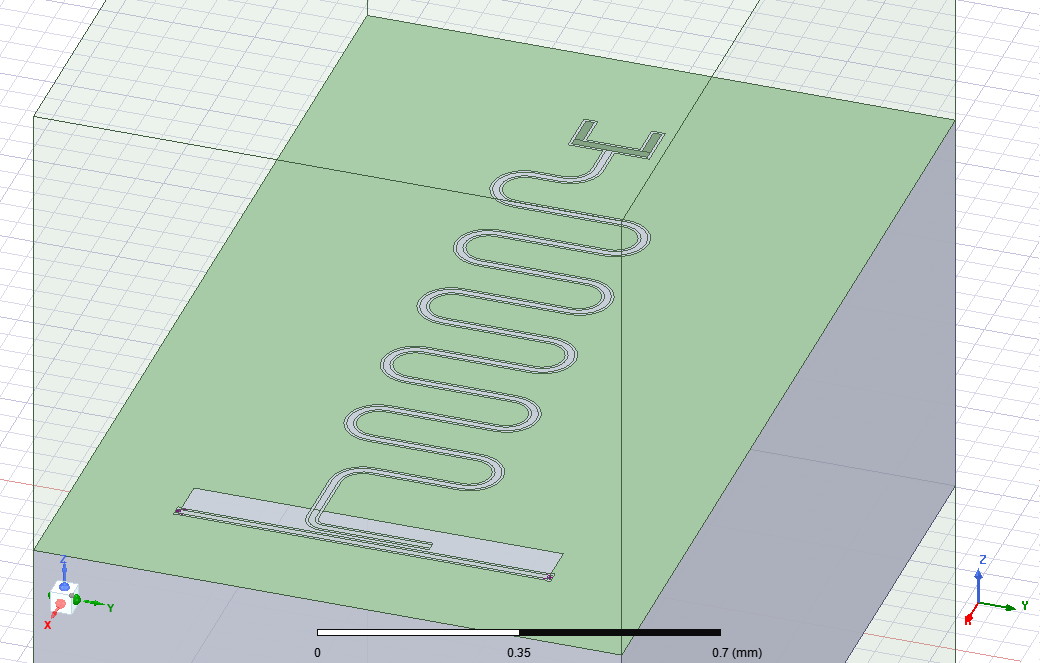

INFO 05:07AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


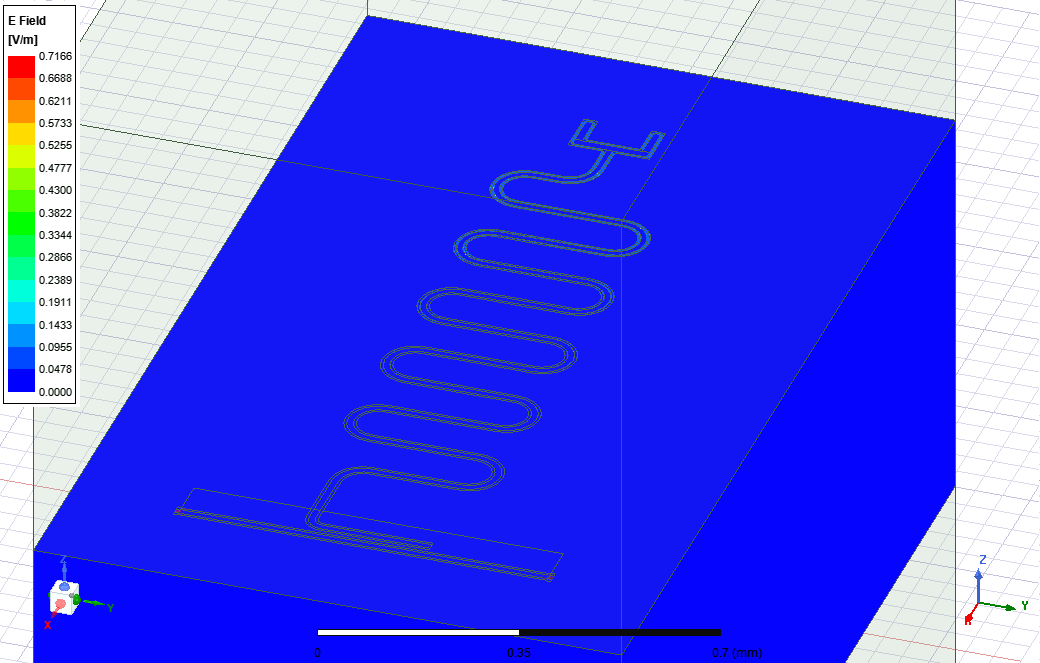

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 05:07AM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:07AM [load_ansys_project]: 	Opened Ansys App
INFO 05:07AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 05:07AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project41


freq = 6.84 GHz
Q = 42423.8
kappa = 0.161 MHz
Starting the Simulation


INFO 05:07AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 05:07AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:07AM [connect]: 	Connected to project "Project41" and design "CavitySweep_hfss" 😀 

INFO 05:07AM [connect_design]: 	Opened active design
	Design:    CavitySweep3 [Solution type: Eigenmode]
WARNING 05:07AM [connect_setup]: 	No design setup detected.
WARNING 05:07AM [connect_setup]: 	Creating eigenmode default setup.
INFO 05:07AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:07AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project Project41 set to active.


INFO:Global:Project Project41 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 05:08AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:08AM [analyze]: Analyzing setup Setup
08:31AM 06s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


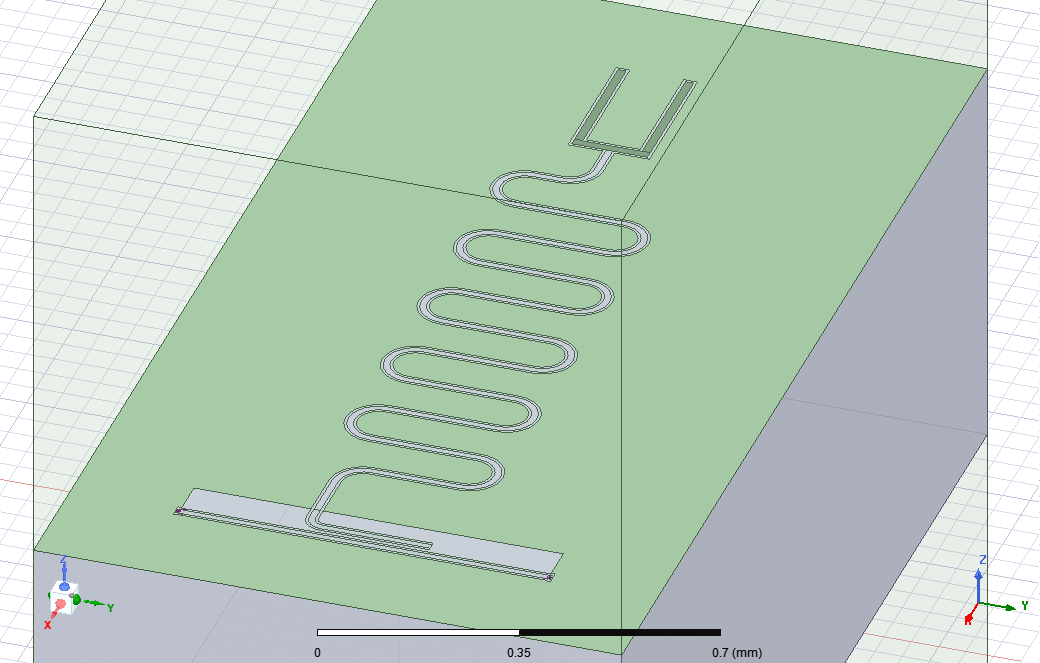

INFO 08:31AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


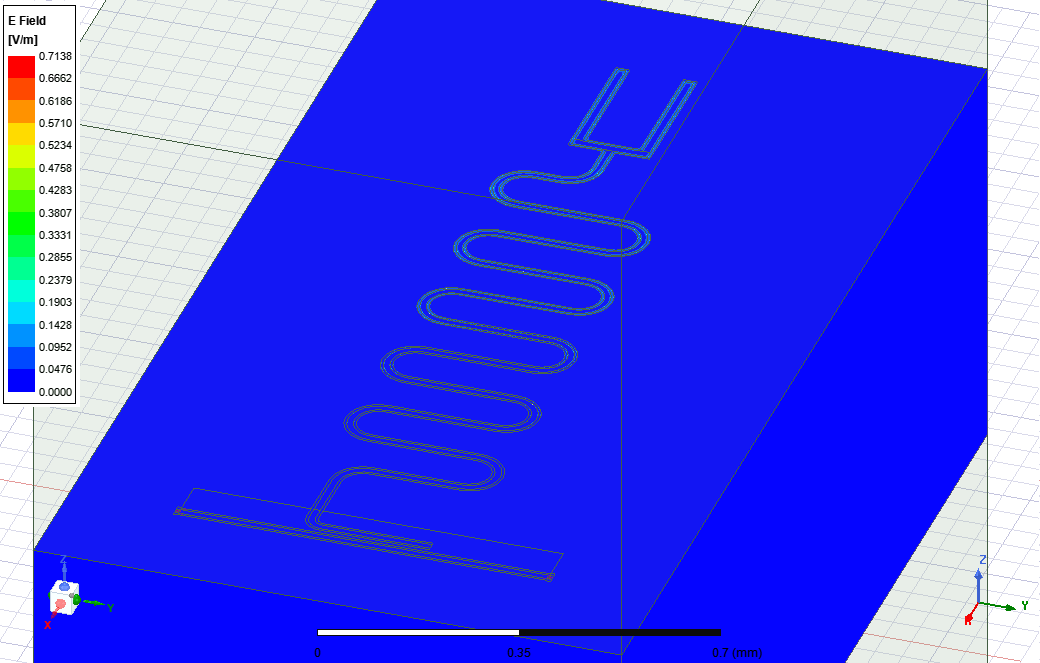

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 08:31AM [connect_project]: Connecting to Ansys Desktop API...
INFO 08:31AM [load_ansys_project]: 	Opened Ansys App
INFO 08:31AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 08:31AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project41


freq = 6.309 GHz
Q = 50872.0
kappa = 0.124 MHz
Starting the Simulation


INFO 08:31AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 08:31AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:31AM [connect]: 	Connected to project "Project41" and design "CavitySweep_hfss" 😀 

INFO 08:31AM [connect_design]: 	Opened active design
	Design:    CavitySweep4 [Solution type: Eigenmode]
WARNING 08:31AM [connect_setup]: 	No design setup detected.
WARNING 08:31AM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:31AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:31AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project Project41 set to active.


INFO:Global:Project Project41 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 08:32AM [__del__]: Disconnected from Ansys HFSS
INFO 08:32AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:32AM [analyze]: Analyzing setup Setup
11:54AM 46s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


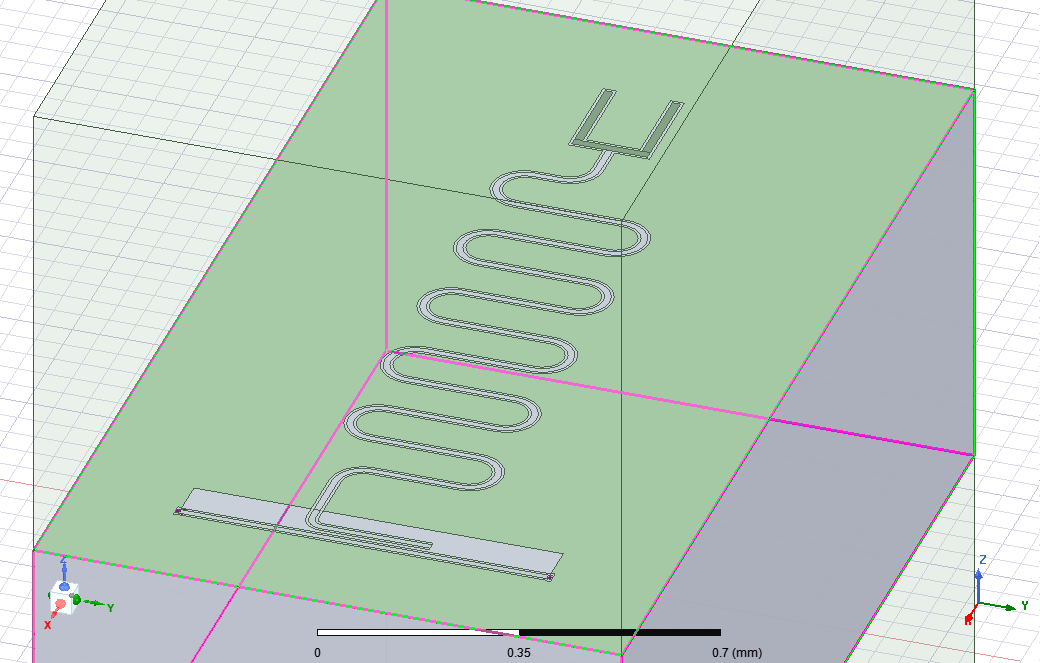

INFO 11:54AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


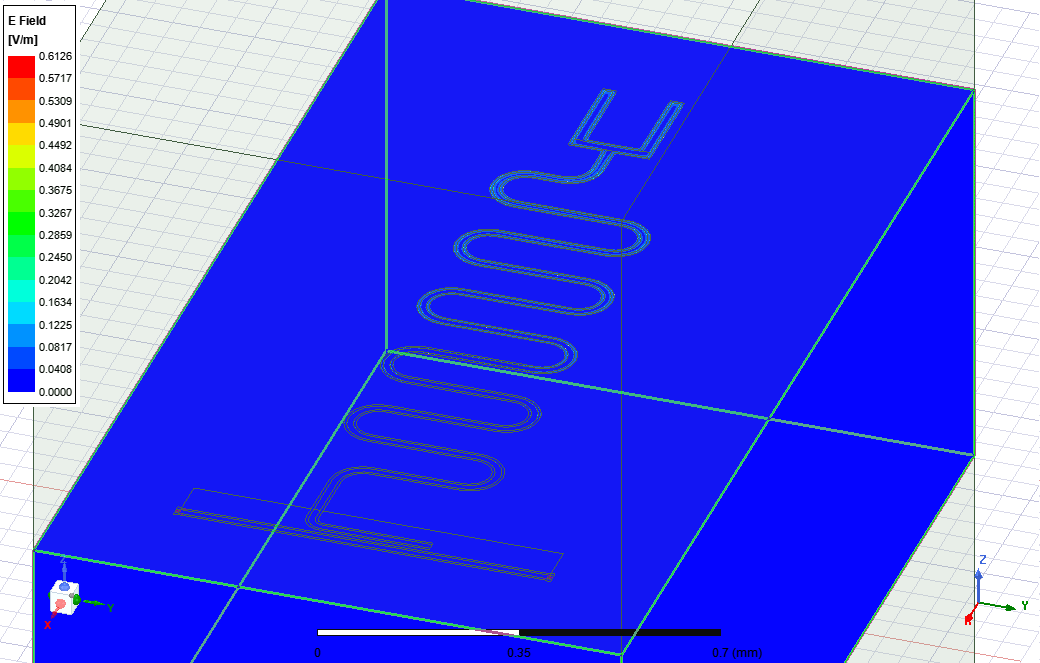

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 11:55AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:55AM [load_ansys_project]: 	Opened Ansys App
INFO 11:55AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:55AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project41


freq = 6.515 GHz
Q = 46003.6
kappa = 0.142 MHz
Starting the Simulation


INFO 11:55AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 11:55AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:55AM [connect]: 	Connected to project "Project41" and design "CavitySweep_hfss" 😀 

INFO 11:55AM [connect_design]: 	Opened active design
	Design:    CavitySweep5 [Solution type: Eigenmode]
WARNING 11:55AM [connect_setup]: 	No design setup detected.
WARNING 11:55AM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:55AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:55AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project Project41 set to active.


INFO:Global:Project Project41 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 11:56AM [__del__]: Disconnected from Ansys HFSS
INFO 11:56AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:56AM [analyze]: Analyzing setup Setup
02:54PM 39s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


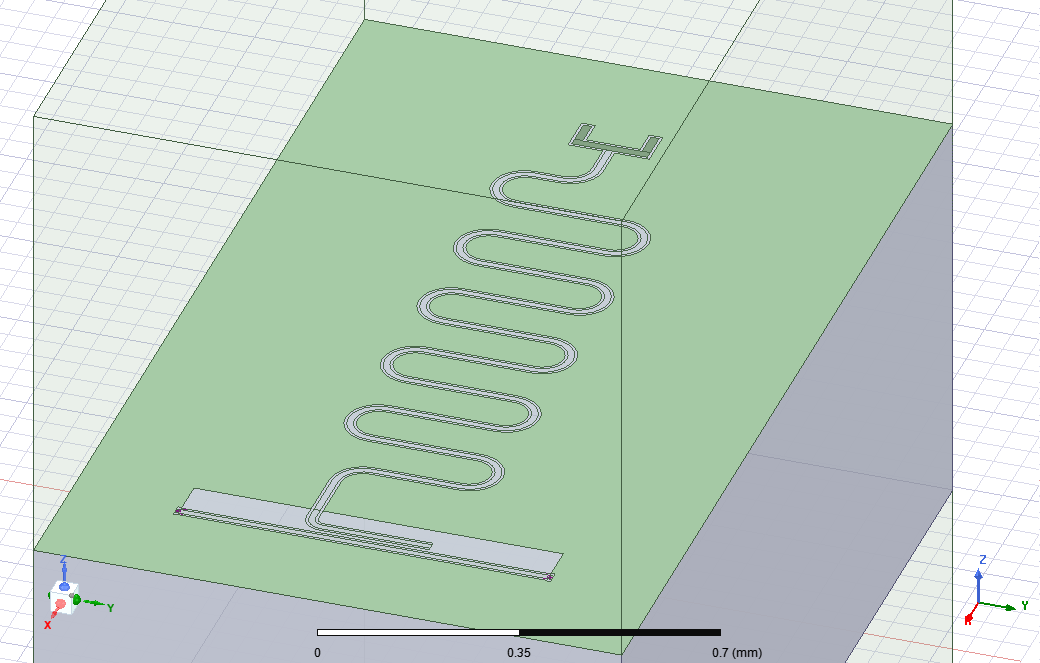

INFO 02:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


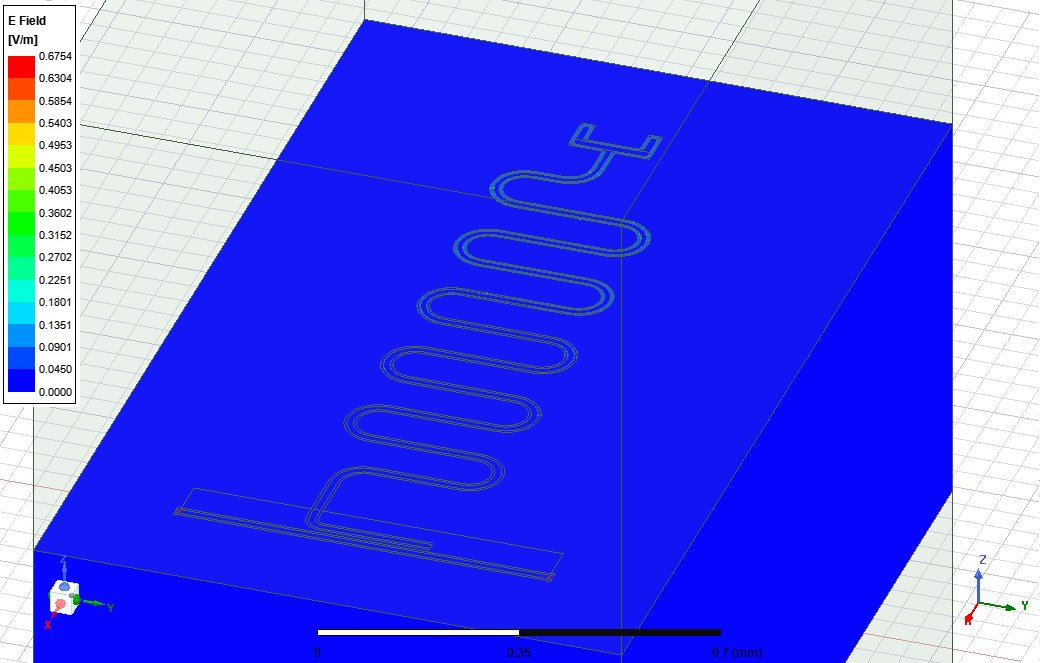

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:55PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:55PM [load_ansys_project]: 	Opened Ansys App
INFO 02:55PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:55PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project41


freq = 6.886 GHz
Q = 42916.1
kappa = 0.16 MHz
Starting the Simulation


INFO 02:55PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 02:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:55PM [connect]: 	Connected to project "Project41" and design "CavitySweep_hfss" 😀 

INFO 02:55PM [connect_design]: 	Opened active design
	Design:    CavitySweep6 [Solution type: Eigenmode]
WARNING 02:55PM [connect_setup]: 	No design setup detected.
WARNING 02:55PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:55PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project Project41 set to active.


INFO:Global:Project Project41 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 02:55PM [__del__]: Disconnected from Ansys HFSS
INFO 02:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:55PM [analyze]: Analyzing setup Setup
06:14PM 08s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


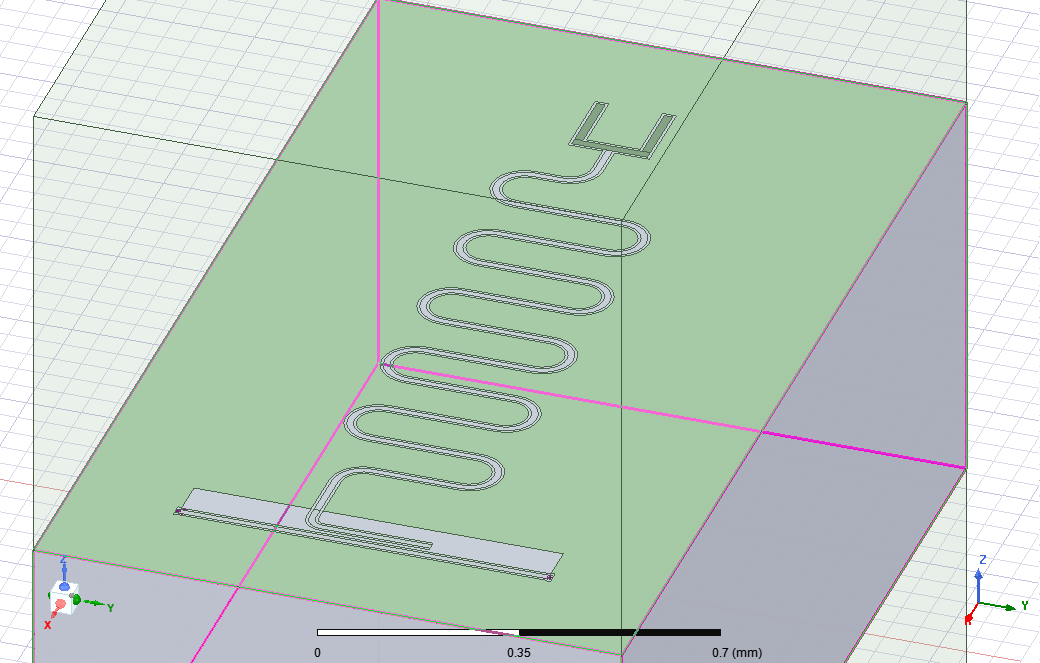

INFO 06:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


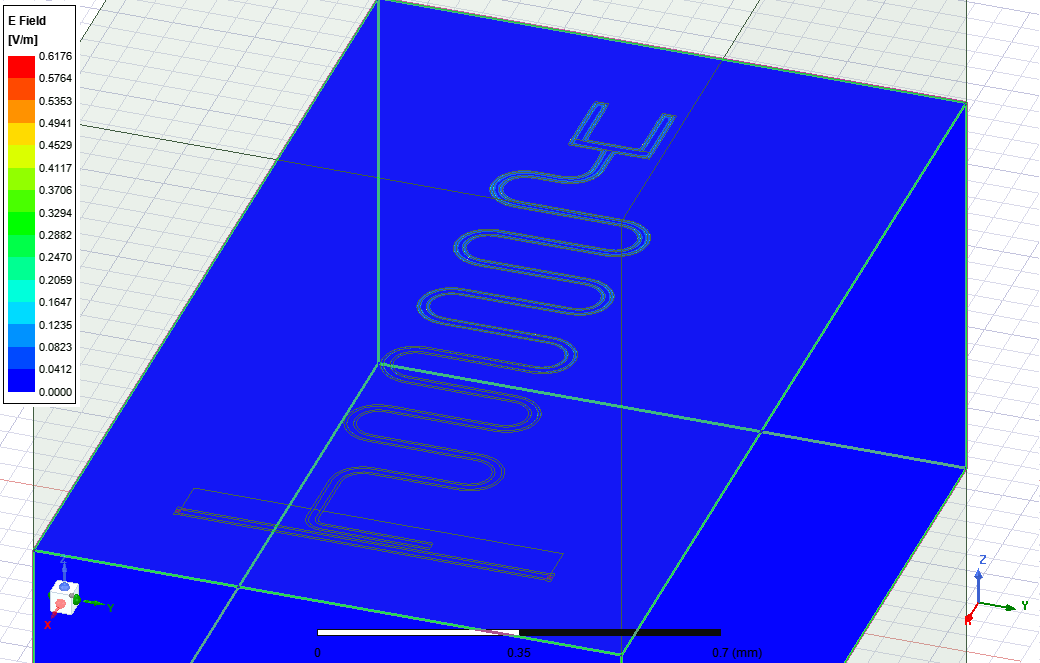

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 6.648 GHz
Q = 44311.5
kappa = 0.15 MHz


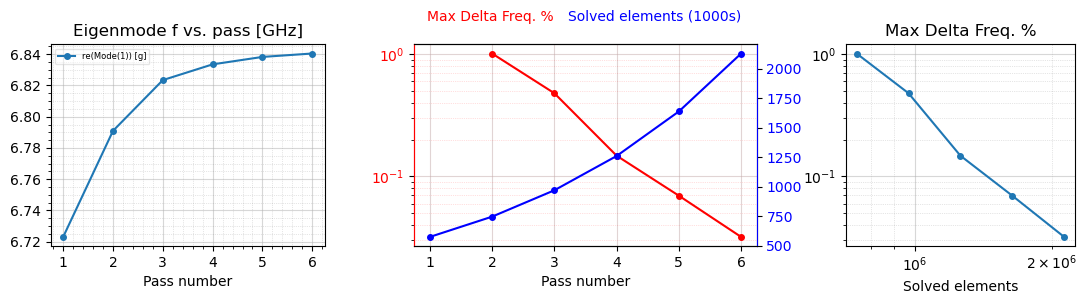

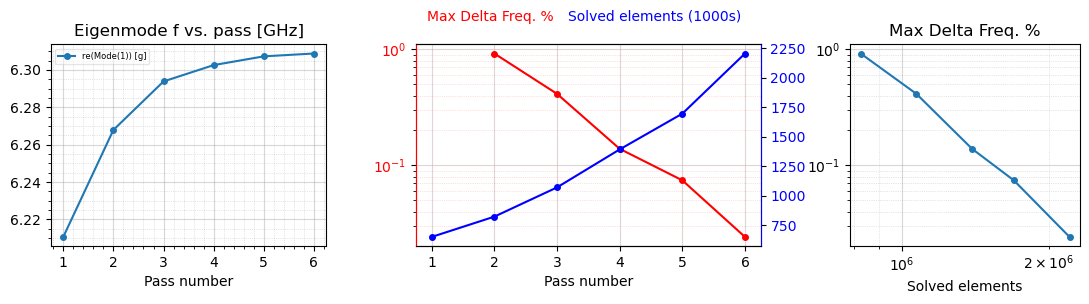

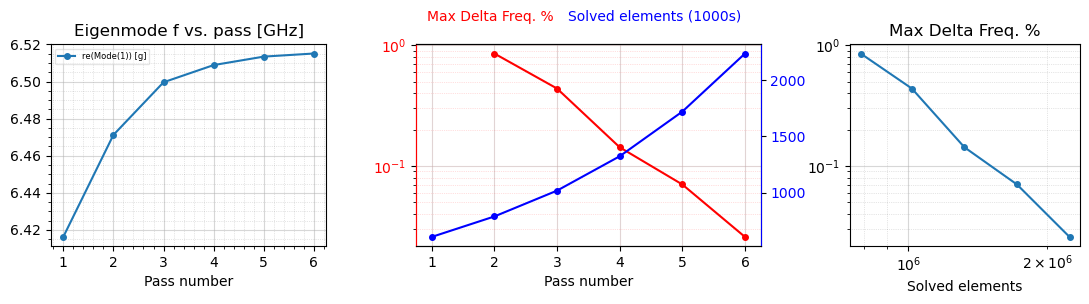

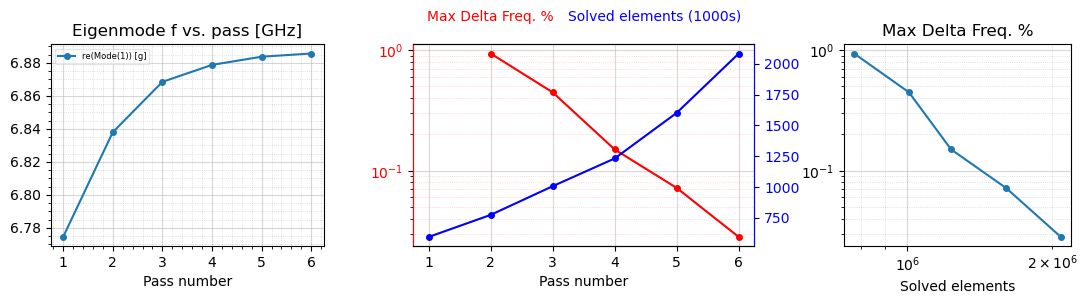

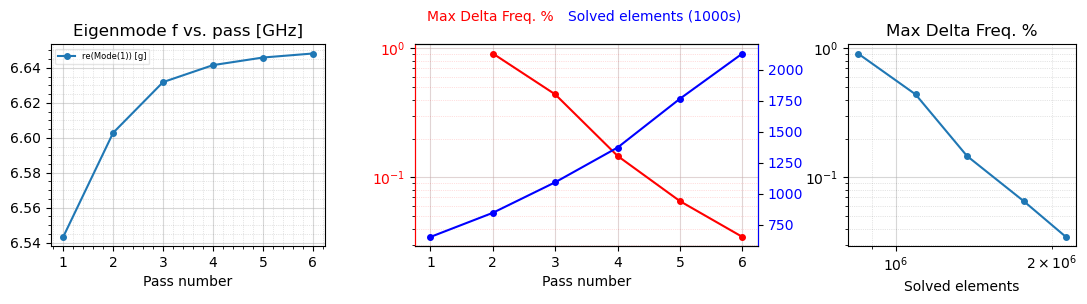

In [9]:
%matplotlib inline
eig_q12bus = EPRanalysis(design, "hfss")
hfss = eig_q12bus.sim.renderer

# i = 4
# setups, hfsss = [], []

# do_eigenmode(predicted_claw_length[1], Lj_vals[1])



for i, (cross_length, claw_length, Lj) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals)):
# claw_length = predicted_claw_length[0]
# Lj = Lj_vals[0]
# i = 0
    # freq, Q, kappa_emode = do_eigenmode(claw_length, Lj, i)
    # data_df = {
    #     "frequency": freq,
    #     "Q": Q,
    #     "kappa_emode": kappa_emode
    # }
        
    # filename = f"cavity_claw_{i}"
    # save_simulation_data_to_json(data_df, filename)
    xmon1_options["connection_pads"]["readout"]["claw_length"] = f"{claw_length}um"
    xmon1_options["aedt_hfss_inductance"]=Lj,
    xmon1_options["hfss_inductance"]=Lj, 
    xmon1_options["q3d_inductance"]=Lj,
    xmon1_options["aedt_q3d_inductance"]=Lj
    
    v2_opts = dict(
        claw_opts = xmon1_options,
        cplr_opts = clt1_opts,
        cpw_opts = cpw1_opts
    )
    CLT_epr_sweep(design = design, sweep_opts=v2_opts, filename = f"cavity_claw_{i}_v2")


# LOM Analysis

In [13]:
xmon = TransmonCross(design = design, options = xmon1_options, name = "xmon")

In [14]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [15]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [16]:
c1.sim.setup.reuse_selected_design = False
c1.sim.setup.reuse_setup = False

# example: update single setting
c1.sim.setup.max_passes = 30
c1.sim.setup.min_converged_passes = 1
c1.sim.setup.percent_error = 0.1
c1.sim.setup.name = 'sweep_setup'

In [25]:
def do_LOM_qubitonly(cross_length, claw_length, Lj, i):
    qname = 'xmon'
    cname = 'readout'

    design.components[qname].options['connection_pads']['readout']['claw_length'] = f'{claw_length}um'
    design.components[qname].options['cross_length'] = f'{cross_length}um'
    design.components[qname].options['hfss_inductance'] = Lj
    design.components[qname].options['aedt_hfss_inductance'] = Lj
    design.components[qname].options['q3d_inductance'] = Lj
    design.components[qname].options['aedt_q3d_inductance'] = Lj
    design.rebuild()

    selection = [qname]
    open_pins = [(qname, cname)]


    c1.sim.run(name = 'LOMv2.0', components=selection,
               open_terminations=open_pins)
    cap_df = c1.sim.capacitance_matrix

    print(f'For Qubit_{i}, the cap matrix is...')
    print(cap_df)

    data = {
        "design_options": design.components[qname].options,
        "data": {
            "cross_to_ground": cap_df.loc[f'cross_{qname}']['ground_main_plane'],
            "claw_to_ground": cap_df.loc[f'{cname}_connector_arm_{qname}']['ground_main_plane'],
            "cross_to_claw": cap_df.loc[f'cross_{qname}'][f'{cname}_connector_arm_{qname}'],
            "cross_to_cross": cap_df.loc[f'cross_{qname}']['ground_main_plane'],
            "claw_to_claw": cap_df.loc[f'{cname}_connector_arm_{qname}'][f'{cname}_connector_arm_{qname}'],
            "ground_to_ground": cap_df.loc['ground_main_plane']['ground_main_plane']
        },
        "sim_info": {
            "setup": c1.sim.setup,
            "renderer_options": c1.sim.renderer.options
        }
    }
    save_simulation_data_to_json(data, filename = f"qubitonly_{i}")


In [28]:
all_cap_matricies = []

for i, (cross_length, claw_length, Lj) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals)):
    if i == 1:
        continue
    do_LOM_qubitonly(cross_length, claw_length, Lj, i)

INFO 01:17AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d7 [Solution type: Q3D]
WARNING 01:17AM [connect_setup]: 	No design setup detected.
WARNING 01:17AM [connect_setup]: 	Creating Q3D default setup.
INFO 01:17AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


<COMObject GetModule>


INFO 01:17AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:17AM [analyze]: Analyzing setup sweep_setup
INFO 01:19AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpx10uhn4n.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:19AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpolglnu2t.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:19AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp091y2rht.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:19AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmplpj72zua.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:19AM [get_matrix]: Exporting matrix dat

For Qubit_0, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                   110.30874         -106.03561   
ground_main_plane           -106.03561          205.85522   
readout_connector_arm_xmon    -2.06168          -48.09054   

                            readout_connector_arm_xmon  
cross_xmon                                    -2.06168  
ground_main_plane                            -48.09054  
readout_connector_arm_xmon                    50.43318  


INFO 01:19AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d8 [Solution type: Q3D]
WARNING 01:19AM [connect_setup]: 	No design setup detected.
WARNING 01:19AM [connect_setup]: 	Creating Q3D default setup.
INFO 01:19AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:19AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:19AM [analyze]: Analyzing setup sweep_setup


<COMObject GetModule>


INFO 01:21AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpnw5wbfuq.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:21AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpgs7ibv50.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:21AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpjbz7mp84.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:21AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpeokf1urk.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:21AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpsq0ok2w_.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell,

For Qubit_2, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                   103.78007          -95.56520   
ground_main_plane            -95.56520          227.92443   
readout_connector_arm_xmon    -5.98393          -82.32222   

                            readout_connector_arm_xmon  
cross_xmon                                    -5.98393  
ground_main_plane                            -82.32222  
readout_connector_arm_xmon                    88.89988  


INFO 01:21AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d9 [Solution type: Q3D]
WARNING 01:21AM [connect_setup]: 	No design setup detected.
WARNING 01:21AM [connect_setup]: 	Creating Q3D default setup.
INFO 01:21AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:21AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


<COMObject GetModule>


INFO 01:21AM [analyze]: Analyzing setup sweep_setup
INFO 01:24AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpht39m2va.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:24AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpolg9ftmj.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:24AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpgx7aiy9r.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:24AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp8n8wz_p6.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:24AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp96eas0ah.txt, C, , sweep_setup:AdaptivePass, "Origin

For Qubit_3, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                   144.11921         -140.25573   
ground_main_plane           -140.25573          241.29450   
readout_connector_arm_xmon    -1.66877          -43.60532   

                            readout_connector_arm_xmon  
cross_xmon                                    -1.66877  
ground_main_plane                            -43.60532  
readout_connector_arm_xmon                    45.48094  


INFO 01:24AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d10 [Solution type: Q3D]
WARNING 01:24AM [connect_setup]: 	No design setup detected.
WARNING 01:24AM [connect_setup]: 	Creating Q3D default setup.
INFO 01:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


<COMObject GetModule>


INFO 01:24AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:24AM [analyze]: Analyzing setup sweep_setup
INFO 01:25AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp1fcxqanv.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:25AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpxzb7o53t.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:25AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp4803dgfv.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:25AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpbak1fo_0.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:25AM [get_matrix]: Exporting matrix dat

For Qubit_4, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                    85.65264          -79.40465   
ground_main_plane            -79.40465          194.35151   
readout_connector_arm_xmon    -4.33128          -67.78899   

                            readout_connector_arm_xmon  
cross_xmon                                    -4.33128  
ground_main_plane                            -67.78899  
readout_connector_arm_xmon                    72.62096  
